# Contact us via Email: donmaston09@gmail.com, learndatascienceonoja125@gmail.com


**What Is an RNN?**

A Recurrent Neural Network (RNN) processes sequences by maintaining a hidden state (memory) that updates at each time step, depending on the current input and the previous state. Traditional RNNs are good for short-term dependencies but struggle with long-term context due to vanishing or exploding gradients during training.

**Why LSTM?**

Long Short-Term Memory (LSTM) networks are a special RNN variant designed to address long-term dependency challenges. They introduce:

- A cell state serving as long-term "memory"

- Three gating mechanisms: input, forget, and output gates
These gates learn when to write, retain, or discard information.

This architecture effectively mitigates vanishing gradients and enables modeling of long-range dependencies in sequential data.

**LSTM Gates and How They Work**
- Forget gate (σ): determines how much previous cell state to retain.

- Input gate (σ) + candidate update (tanh): decides what new information to write.

- Output gate (σ): controls what part of cell state to output.

Together, they dynamically control memory flow, enabling the network to hold onto useful past context while discarding noise.

**When to Use LSTM?**

Ideal for tasks requiring sequence modeling:

- Time series forecasting (e.g. stock prices, weather)

- Natural language processing (e.g. text generation, translation)

- Audio/speech recognition, music composition, user behavior prediction, etc.

Though more complex and slower to train than simpler models like GRUs, LSTMs often outperform when handling longer sequences.

**TensorFlow + Keras Implementation Overview**

In this hand-on session, we will demonstrates building LSTM in TensorFlow's tf.keras, covering:

- How to preprocess sequential data

- Define an LSTM(units=…, return_sequences=…) layer

- Compile with optimizer/loss and train the model

- Evaluate and generate predictions on new data

This hands-on approach helps students understand both the conceptual architecture and the practical code implementation.

**🎯 Learning Objectives**

- By the end of this session, students will be able to:

- Understand the limitations of traditional RNNs.

- Explain the internal architecture of LSTM units.

- Identify use cases where LSTM is effective.

- Implement LSTM in TensorFlow/Keras on sequential data.




In [ ]:
# 1. Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Step 1: Import required libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Step 2: Mount Google Drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

# Step 3: Load your data (adjust path as needed)
# Make sure this path points to the correct location in your Google Drive
file_path = '/content/drive/MyDrive/monthly_milk_production.csv'
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


In [ ]:
data.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [ ]:
data.tail()

,Date,Production
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797
167,1975-12,843


In [ ]:
# Step 4: Convert 'Date' to datetime format and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [ ]:
# Step 5: Extract the 'Production' column and normalize it
production = data['Production'].astype(float).values.reshape(-1, 1)


In [ ]:
# Step 1: Basic information
print("Shape of the dataset:", data.shape)
print("\nData Types:\n", data.dtypes)
print("\nMissing Values:\n", data.isnull().sum())

Shape of the dataset: (168, 1)

Data Types:
 Production    int64
dtype: object

Missing Values:
 Production    0
dtype: int64


In [ ]:
# Step 2: Summary statistics
print("\nDescriptive Statistics:\n")
print(data.describe())



Descriptive Statistics:

       Production
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000


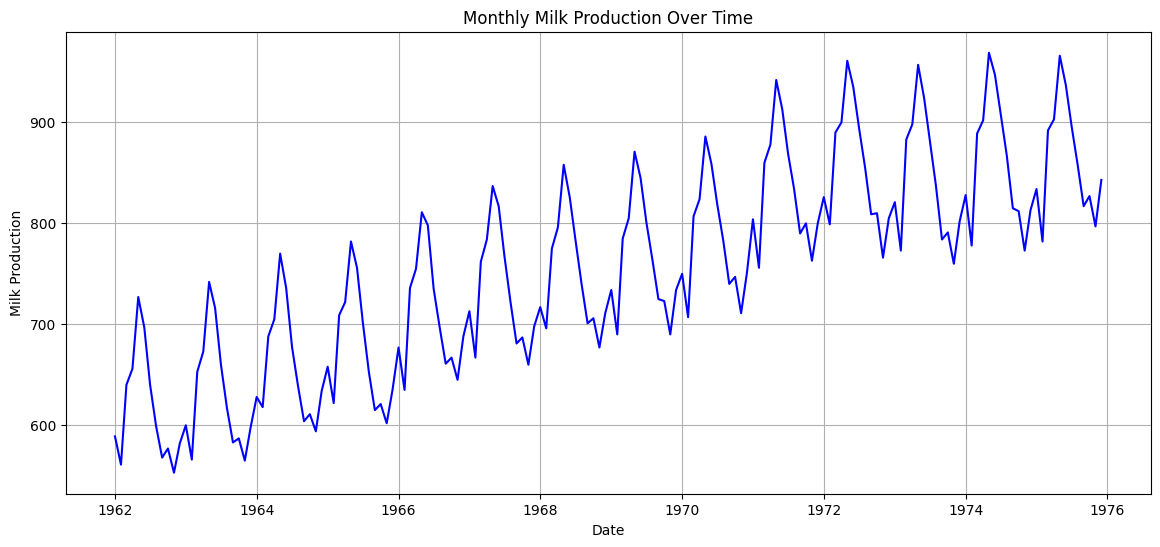

In [ ]:
### Perform EDA

# Step 3: Line plot of milk production over time
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Production'], color='blue')
plt.title('Monthly Milk Production Over Time')
plt.xlabel('Date')
plt.ylabel('Milk Production')
plt.grid(True)
plt.show()

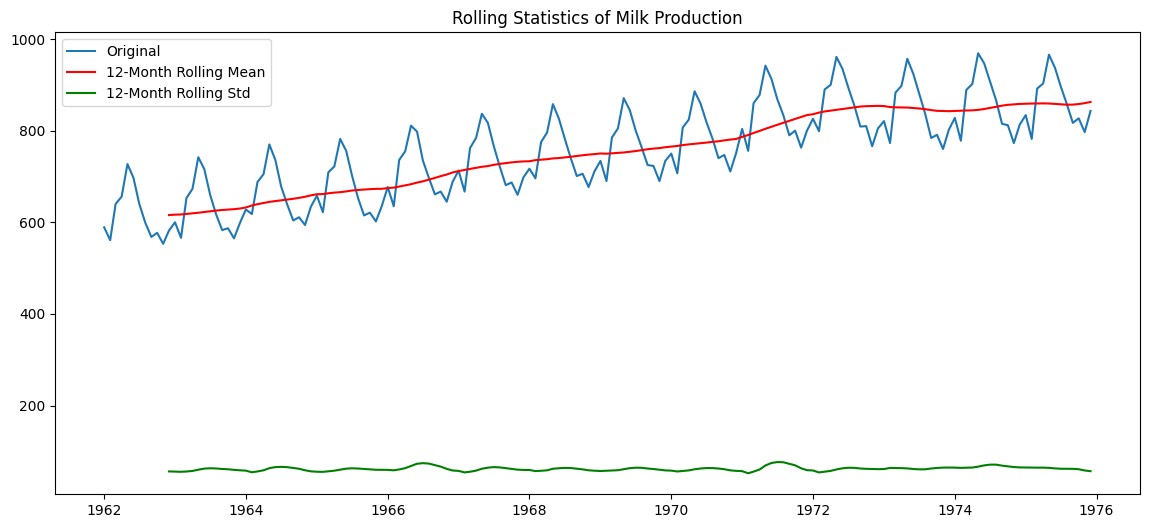

In [ ]:
# Step 4: Plotting rolling statistics (mean and std)
rolling_mean = data['Production'].rolling(window=12).mean()
rolling_std = data['Production'].rolling(window=12).std()

plt.figure(figsize=(14, 6))
plt.plot(data['Production'], label='Original')
plt.plot(rolling_mean, label='12-Month Rolling Mean', color='red')
plt.plot(rolling_std, label='12-Month Rolling Std', color='green')
plt.title('Rolling Statistics of Milk Production')
plt.legend()
plt.show()

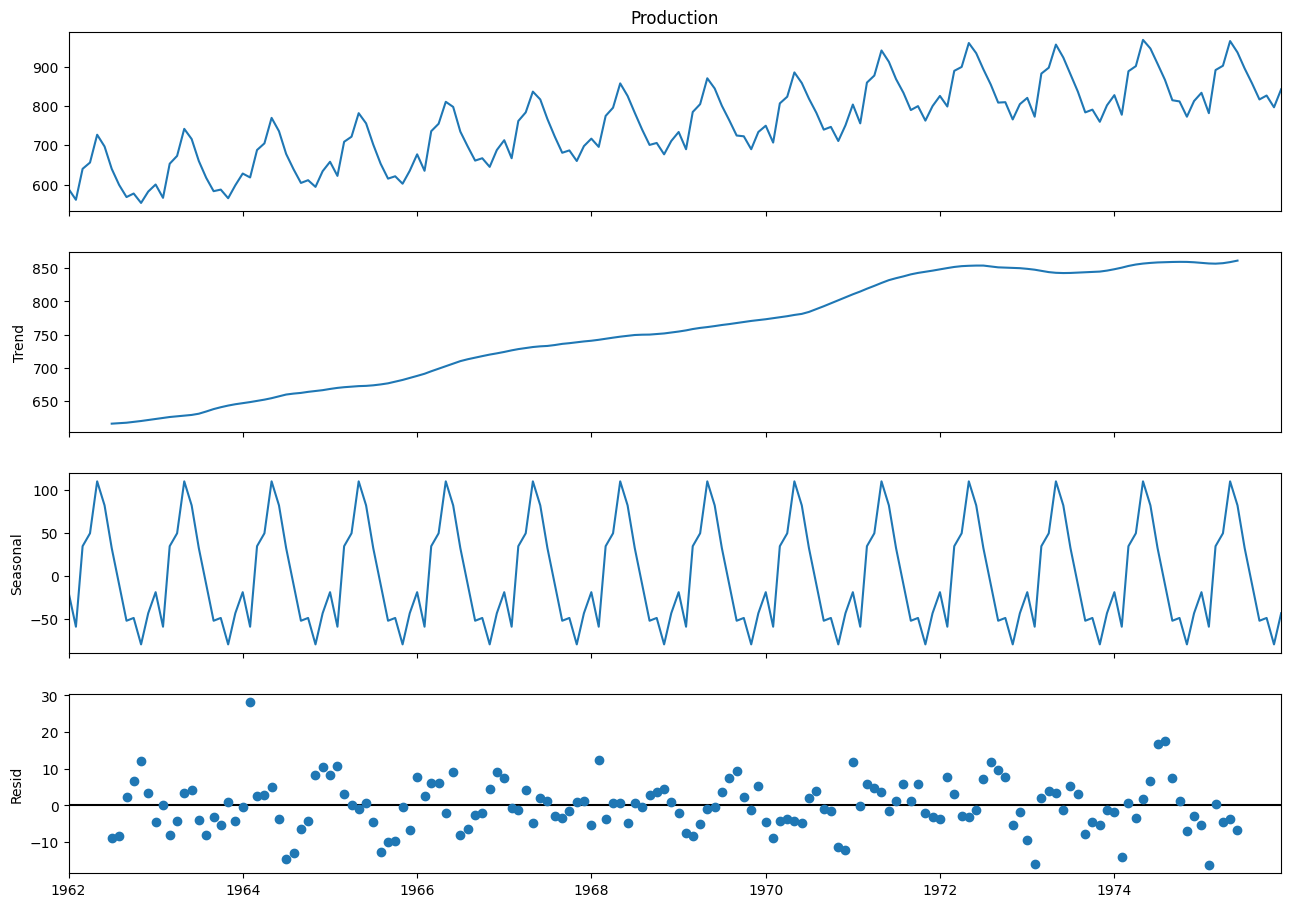

In [ ]:
# Step 5: Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['Production'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()


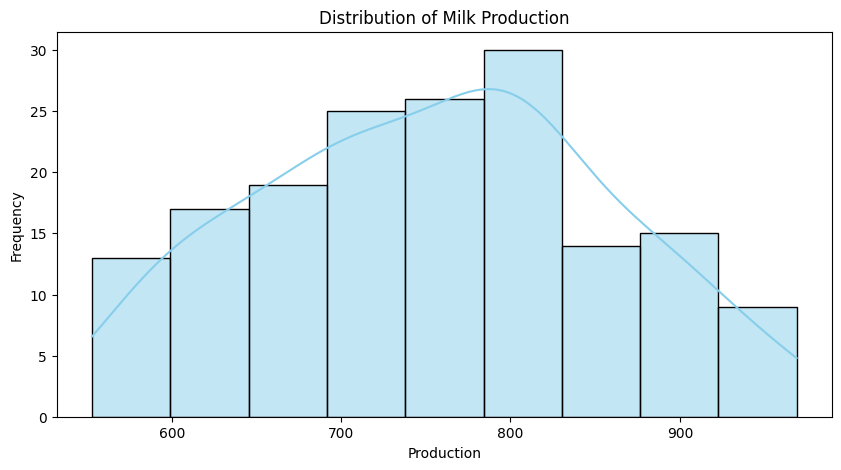

In [ ]:
# Step 6: Histogram & density plot
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(data['Production'], kde=True, color='skyblue')
plt.title('Distribution of Milk Production')
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.show()

In [ ]:
### Scaled the Dataset

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(production)

In [ ]:
## Creating Sequences and Train-Test Split

window_size = 12
X = []
y = []
target_dates = data.index[window_size:]

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, target_dates, test_size=0.2, shuffle=False
)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

**Building the LSTM Model**

This step involves defining and building the LSTM model architecture.

- The model consists of two LSTM layers, each with 128 units and a dropout layer after each to prevent overfitting.
- The model concludes with a Dense layer to predict a single value (next month's production).

In [ ]:
# Build the Model Architecture

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Training and Evaluating the Model**

In this step, we train the model on the training data and evaluate its performance.

- The model is trained for 100 epochs using a batch size of 32, with 10% of the training data used for validation.

- After training the model is used to make predictions on the test set and we calculate the Root Mean Squared Error (RMSE) to evaluate performance.

In [ ]:
# Model Training

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

rmse = np.sqrt(np.mean((y_test - predictions)**2))
print(f'RMSE: {rmse:.2f}')

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.1455 - val_loss: 0.0271
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0390 - val_loss: 0.0343
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0288 - val_loss: 0.0641
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0368 - val_loss: 0.0612
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0366 - val_loss: 0.0286
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0265 - val_loss: 0.0273
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0258 - val_loss: 0.0290
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0260 - val_loss: 0.0400
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0288 - val_loss: 0.0301
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0234 - val_loss: 0.0262
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0255 - val_loss: 0.0282
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0247 - val_l

**Visualizing Model Performance**

In this step, we visualize the actual vs predicted values. A plot is generated to compare the actual milk production against the predicted values, allowing us to evaluate how well the model performs over time.

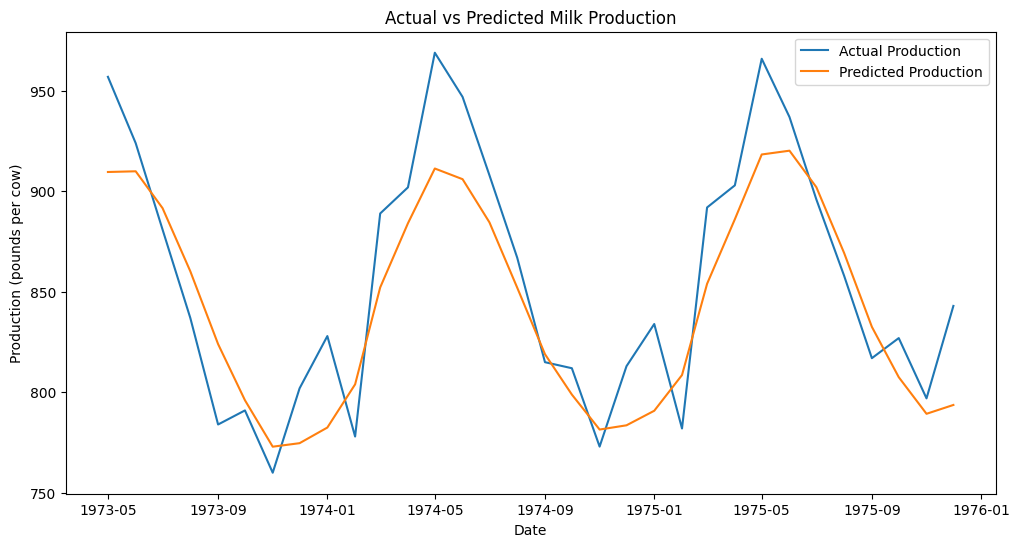

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test, label='Actual Production')
plt.plot(dates_test, predictions, label='Predicted Production')
plt.title('Actual vs Predicted Milk Production')
plt.xlabel('Date')
plt.ylabel('Production (pounds per cow)')
plt.legend()
plt.show()